# ASTR 596 Computer lab - Image combination and photometry (50 points)

In this lab you will learn how to:
* combine a set of astrometrically aligned images
* measure the size of stars in each of these images
* measure fluxes of objects in each image
* convert these to magnitudes
* match sources in the two catalogs
* plot H-R diagrams for the cluster

<i>Note: Enter in all code to the problems in the provided notebook cells. Questions to answer will be <b>bolded</b>.</i>  

All your answers should be entered in this notebook. Each student will need to hand in their own notebook by uploading it to GitHub following the instructions.

In the code places where you will need to put something or write your own code are specified by `#***************`  You will not get points for doing this unless explicitly noted.  Some of these things are just to make sure you are setting up your paths correctly.

**Due on Nov. 18 at Noon** to be handed into the "Image Combinaton and Photometry" assignment in Module 8.

Thanks to Prof. Rose Finn for her work in reducing the individual images of M29 and for providing them to us.

**You will need to download the raw data.  You can access it at**

**https://www.dropbox.com/t/wqpOzykI2Q9vznIF**

I suggest you make a directory on your computer called `~/ASTR596/Data` and put data in there.  

In [51]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.io import fits
import glob
import os
from scipy.stats import scoreatpercentile

from matplotlib import pyplot as plt
import numpy as np

#import ccdproc

from astropy.nddata import CCDData
import astropy.units as u
from ccdproc import ImageFileCollection, Combiner, combine
from ccdproc import wcs_project


### Some functions to display the images and overplot the stars

In [52]:
def imdisplay(image, v1perc=10, v2perc=95):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    plt.imshow(nimage,cmap='gray_r',vmin=v1,vmax=v2)
    plt.colorbar(fraction=.08)
    
def add_stars(xstars,ystars,radius=20,color='r',ax=None):
    ''' this will add circles at the location of xstars,ystars '''
    if ax is None:
        ax = plt.gca()
    allcircles=[]
    #The zip function takes iterables (e.g. lists or arrays) and groups them into tuples that contain 
    #matched pairs of each input, e.g [(x,y)]
    for x,y in zip(xstars,ystars):
        c = plt.Circle((x,y),radius,color=color,fill=False)
        #allcircles.append(c)
        ax.add_artist(c)

In [53]:
#set the directory with your data
#*********************
#you will need to modify this with your own directory
datadir = '/home/l533c367/ASTR596/DATA'

#change directory to the data directory
os.chdir(datadir)


### Display one image in each filter 
This will let you see what the data in each filter looks like.  There are multiple images taken in each band.  The following blocks of code each display the first image taken in each band.

Text(0.5, 1.0, 'B-band image')

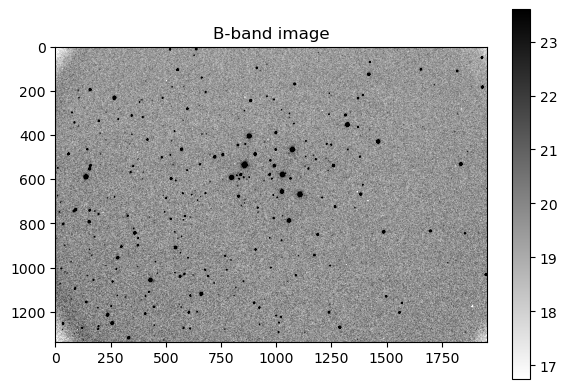

In [54]:
#make the figure
plt.figure()

#read in the data and header
data,header = fits.getdata('cazfdp-M29-0001b.fits', header=True)

#use our custom made subroutine from above to plot the image
imdisplay(data)
plt.title("B-band image")

Text(0.5, 1.0, 'V-band image')

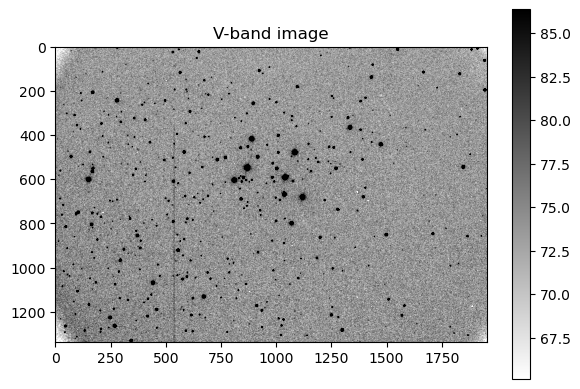

In [55]:
#make the figure
plt.figure()

#read in the data and header
data,header = fits.getdata('cazfdp-M29-0001g.fits', header=True)

#use our custom made subroutine from above to plot the image
imdisplay(data)
plt.title("V-band image")

Text(0.5, 1.0, 'R-band image')

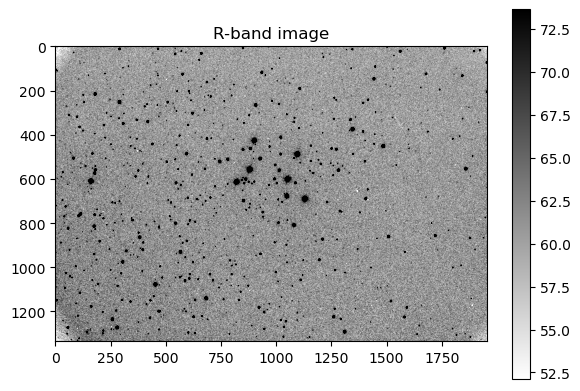

In [56]:
#make the figure
plt.figure()

#read in the data and header
data,header = fits.getdata('cazfdp-M29-0001r.fits', header=True)

#use our custom made subroutine from above to plot the image
imdisplay(data)
plt.title("R-band image")

### determine how subsequent images in a single band differ

Use ds9 to display the 0001, 0002, and 0003 images for the $B$ band.  Display each image in a separate frame by creating a new frame in the horizontal button bar and opening the file into that frame.  Use the `scale->zscale` button to display the stretch better.

By hitting the Tab key you can cycle through the images.  Shift-Tab cycles through them in reverse order.  You can also use the Blink button or the Tile button under the Frame button to blink the images.

### Problem 1 (6 points)
The main difference between the plots lies in the positional variation of the sources. These shifts likely occur due to dithering, which offsets the field of view slightly between observations to reduce detector artifacts and improve data quality. In this case, the sources appear to move by approximately 20 pixels between frames, resulting in slight differences in alignment across the B, V, and R-band images.

**put answer here**: The main difference I notice is that the astros are in different places from frame to frame, and that is mainly because they are moving in the space and the frames were taken in different times. 

### Combine the images in each filter.

Reference: https://ccdproc.readthedocs.io/en/latest/image_combination.html

Note: $BVR$ images have extensions $bgr$ in our data set.  These images have had their bias correction, dark current, flatfielding, astrometry, and photometric zeropoint all measured and have had cosmicrays removed.

We will use a new task called `glob.glob` which finds all the files in a current directory that match a certain syntax.

The image combination has multiple steps
* get a list of the images in each band.  
* Each image has a slightly different pointing because the telescope was dithered around.
* establish which WCS you will use as a target onto which all the other images will be aligned.
* use a task called `reproject` to align all of the images using the reference
* Students will need to write code to combine 2 of the 3 sets of images.


In [57]:
#for example, to get a list of all the images
image_list = glob.glob('ca*.fits')
print(image_list)

['cazfdp-M29-0001g.fits', 'cazfdp-M29-0001r.fits', 'cazfdp-M29-0002r.fits', 'cazfdp-M29-0005g.fits', 'cazfdp-M29-0004g.fits', 'cazfdp-M29-0002b.fits', 'cazfdp-M29-0005r.fits', 'cazfdp-M29-0004b.fits', 'cazfdp-M29-0002g.fits', 'cazfdp-M29-0005b.fits', 'cazfdp-M29-0003r.fits', 'cazfdp-M29-0003g.fits', 'cazfdp-M29-0004r.fits', 'cazfdp-M29-0003b.fits', 'cazfdp-M29-0001b.fits']


In [58]:
#*****************
#Using the above code as a reference, create lists of images in each band
#First we need to get a list for images in each filter
rimage_list = glob.glob('*r.fits')
gimage_list = glob.glob('*g.fits')
bimage_list = glob.glob('*b.fits')

#read in the first r-band image in that list using fits.getdata.  This image will be used as a target whose WCS
# will be used for all other images to be transformed onto
rimage, rheader = fits.getdata(rimage_list[0],header=True)
target_wcs = WCS(header)

print(target_wcs)
#**********************
#now print out each of the image lists to see if they make sense
print(rimage_list)
print(gimage_list)
print(bimage_list)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 305.979554574 38.5221094171 
CRPIX : 977.5 668.5 
CD1_1 CD1_2  : 0.000213779024462 -6.70567456134e-05 
CD2_1 CD2_2  : 6.71084281872e-05 0.000213787720685 
NAXIS : 1954  1336
['cazfdp-M29-0001r.fits', 'cazfdp-M29-0002r.fits', 'cazfdp-M29-0005r.fits', 'cazfdp-M29-0003r.fits', 'cazfdp-M29-0004r.fits']
['cazfdp-M29-0001g.fits', 'cazfdp-M29-0005g.fits', 'cazfdp-M29-0004g.fits', 'cazfdp-M29-0002g.fits', 'cazfdp-M29-0003g.fits']
['cazfdp-M29-0002b.fits', 'cazfdp-M29-0004b.fits', 'cazfdp-M29-0005b.fits', 'cazfdp-M29-0003b.fits', 'cazfdp-M29-0001b.fits']


###  Combine the images

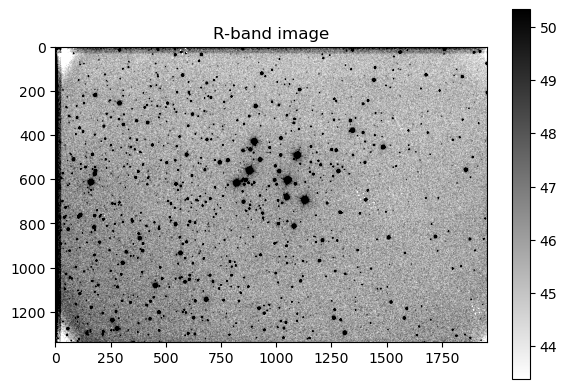

In [59]:
# We will reproject all the images to align them with the first image in each of the lists for a given filter.
#start with the R-band data
reprojected = []
#loop through each image name
for image_name in rimage_list:
    #read the image into a "CCDData" object
    img = CCDData.read(image_name)
    #take each image, and reproject it onto an identical coordinate grid to the target image
    new_image = wcs_project(img, target_wcs)
    #this is a list of all the reprojected images
    reprojected.append(new_image)

# combine the reprojected images into one image
combiner = Combiner(reprojected)
stacked_image = combiner.average_combine()


# save the combined image
fits.writeto('M29R.fits',stacked_image,overwrite=True,header=rheader)
# display the combined image
plt.figure()
imdisplay(stacked_image)
plt.title('R-band image')
plt.show()


## Problem 2a (4 points) - combine exposures for the V and B-band images

You must new repeat this for the V and B-band images and trim all three images to remove bad data at the edges of the image.

/home/l533c367/micromamba/envs/stenv/lib/python3.12/site-packages/ccdproc/combiner.py:548: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/l533c367/micromamba/envs/stenv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


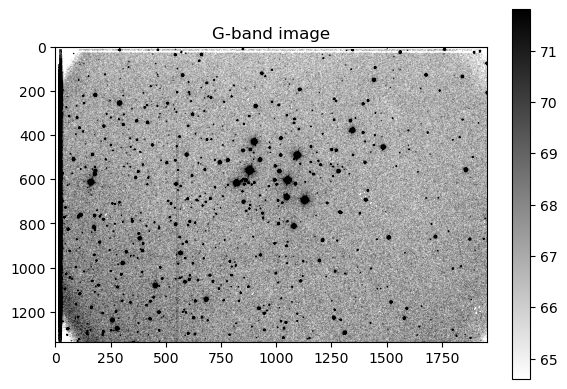

In [60]:
#*********************
#repeat for the G-band images
reprojected = []
#loop through each image name
for image_name in gimage_list:
    #read the image into a "CCDData" object
    img = CCDData.read(image_name)
    #take each image, and reproject it onto an identical coordinate grid to the target image
    new_image = wcs_project(img, target_wcs)
    #this is a list of all the reprojected images
    reprojected.append(new_image)

# combine the reprojected images into one image
combiner = Combiner(reprojected)
stacked_image = combiner.average_combine()


# save the combined image
fits.writeto('M29G.fits',stacked_image,overwrite=True,header=rheader)
# display the combined image
plt.figure()
imdisplay(stacked_image)
plt.title('G-band image')
plt.show()


/home/l533c367/micromamba/envs/stenv/lib/python3.12/site-packages/ccdproc/combiner.py:548: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/l533c367/micromamba/envs/stenv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


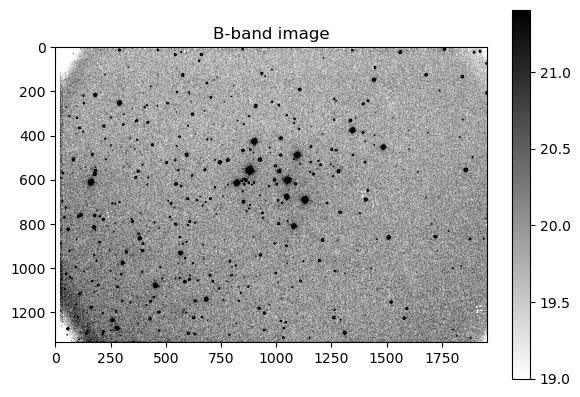

In [61]:
#*********************
#repeat for the B-band images
#I use the same information they gave to us in the sample question before .
reprojected = []
#loop through each image name
for image_name in bimage_list:
    #read the image into a "CCDData" object
    img = CCDData.read(image_name)
    #take each image, and reproject it onto an identical coordinate grid to the target image
    new_image = wcs_project(img, target_wcs)
    #this is a list of all the reprojected images
    reprojected.append(new_image)

# combine the reprojected images into one image
combiner = Combiner(reprojected)
stacked_image = combiner.average_combine()


# save the combined image
fits.writeto('M29B.fits',stacked_image,overwrite=True,header=rheader)
# display the combined image
plt.figure()
imdisplay(stacked_image)
plt.title('B-band image')
plt.show()


## Problem 2b (2 points) - How would you remove cosmicrays?

Assume that there are some cosmicrays in each of the individual images in each band.  Using the manual for image combination that is linked to right after problem one, describe how you would alter the code above to reject cosmicrays as part of the combination.  You may try to combine the images with this method.

**put answer here**: 
In chapter 9 from the book it mentions that the sigma clipping is good for removing cosmic rays or bad pixels.

### What if we want to display our images using RA and DEC?

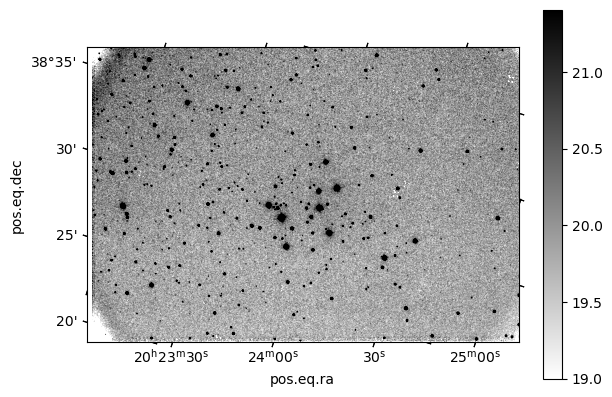

In [62]:
plt.subplot(projection=target_wcs)
imdisplay(stacked_image)

## Problem 3 - Measure the FWHM of stars using imexam (6 points)

imexam is a powerful image quick look tool to examine the images.  More info is at https://imexam.readthedocs.io/en/0.9.1/index.html

As it is a finiky package, to use it we will need to make a new environment.  You should do so with the following command from a new prompt that is in your base conda environment:

`micromamba create --name env1 python==3.8 astropy==5.2.2 imexam=0.9.1 --channel conda-forge `

This environment will only be used with imexam.

In at terminal in the same directory as your data type `ipython`.  At the ipython command line type the following commands, each on their own line
* import imexam
* viewer=imexam.connect()   #start a ds9 window
* viewer.load_fits('M29B.fits')  #loads an image
* viewer.scale()   #change to the default zscale
* viewer.imexam() #start the interactive tool.

You will see a set of cursor commands.  By putting the cursor over a star in the image and hitting the `a` key you will get a measure of the FWHM in the image.  Sometimes you will get an error about the plot window timing out.  If you click back on the DS9 window you should be able to hit the key again.

Do this for 5 bright but unsaturated stars in each image and take the average to get the FWHM of your image.  Note that imexam outputs the FWHM in pixels.  You can use the `r` key in imexam to print a radial profile that you can use to see if the image is saturated.  **Don't trust the FWHM from the radial plot.  I don't think it is correct.**

Fill in those values below


FWHM of B-band image (in pix): 4.3

FWHM of V-band image (in pix): 3.95

## Problem 4 - Measure the photometry of the stars using photutils (8 points) 

DAOStarFinder is a program that detects objects in images using the same method we talked about in class.

In addition to writing the code for this section, I also want you to make a plot of the number of detected sources for different values of the "threshold" parameter in DAOStarFinder.  Do this for The B and V-bands and and comment on how the behavior of the number of sources depends on the threshold value for each band.

In [63]:
#read in the B-band image
data_b, header_b = fits.getdata('M29B.fits',header=True)

In [64]:
# estimate the background counts in the image by computing the 
# mean and median excluding all pixels greater than 3-sigma above the mean
mean_b, median_b, std_b = sigma_clipped_stats(data_b, sigma=3.0)

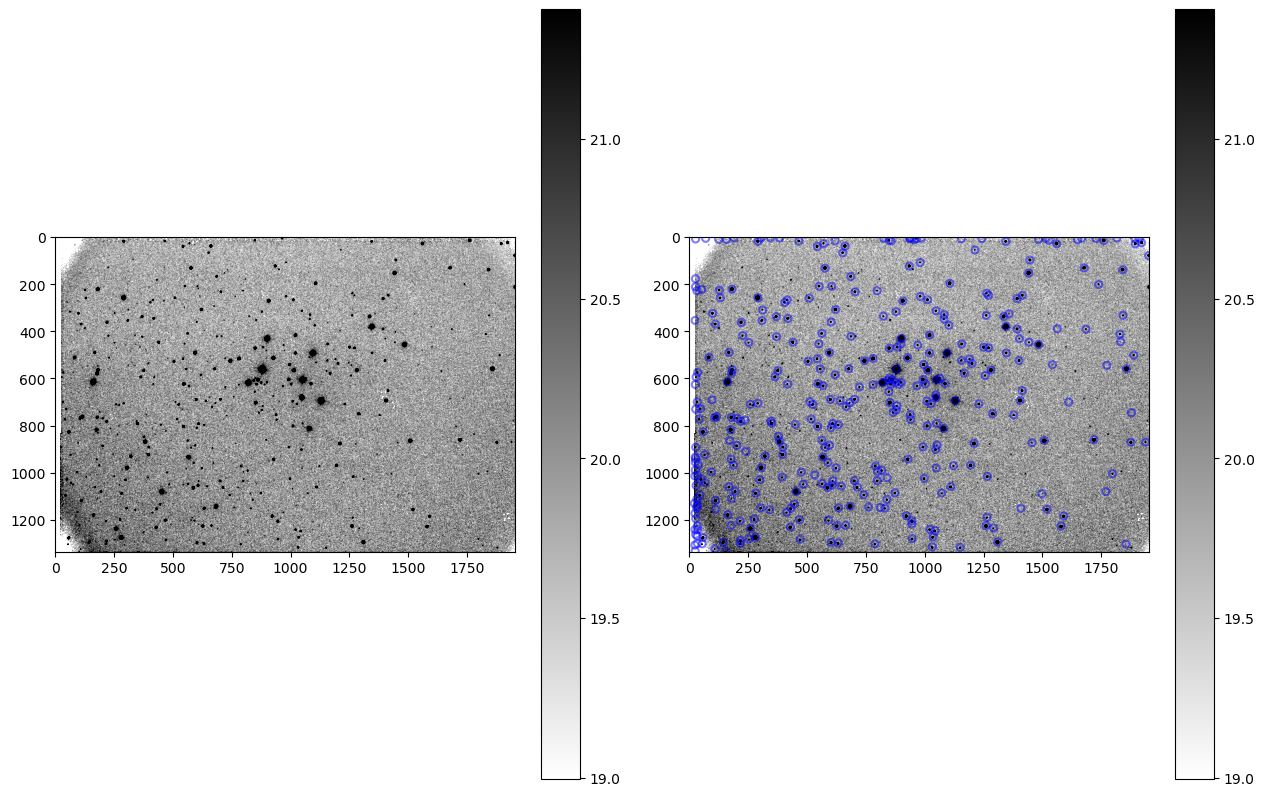

In [65]:
# Set up the DAOStarFinder to find stars in our image.
# We're telling it the size of stars (fwhm) and how bright a source needs to be to be considered (threshold).
#*****************************************
# Update this value once we get the FWHM from imexam or another method. 
# For now, we'll use this placeholder value.
daofind = DAOStarFinder(fwhm=4.3, threshold=5.*std_b)  # I fixed the threshold here.

# Now, let's detect the stars in the image. We're subtracting the background (sky) using the median value of the image.
# This helps to isolate the stars by removing the sky's brightness.
sources_b = daofind(data_b - median_b)  # Run the DAOStarFinder to detect the stars.

# Next, convert the pixel positions of the stars to real-world coordinates (RA and Dec).
# We do this using the WCS info from the image header (header_b).
wcs_b = WCS(header_b)  # Get the WCS info from the image header.
ra_b, dec_b = wcs_b.wcs_pix2world(sources_b['xcentroid'], sources_b['ycentroid'], 0) 
# Convert the star positions from pixels to RA/Dec.

# Let's make a plot! We'll show the image and the detected stars side by side.
plt.figure(figsize=(15, 10))  # Set the size of the plot.

# On the left, show the raw B-band image.
plt.subplot(1, 2, 1)  # This is the first plot in a 1x2 grid.
imdisplay(data_b)  # Display the B-band image.

# On the right, show the B-band image again but with circles marking the detected stars.
plt.subplot(1, 2, 2)  # This is the second plot in the grid.
# Get the positions of the stars and prepare them for plotting (transpose to get the right format).
positions = np.transpose((sources_b['xcentroid'], sources_b['ycentroid']))  
# Create circular apertures (15 pixels in radius) at each detected star's position.
apertures = CircularAperture(positions, r=15.)  
imdisplay(data_b)  # Display the B-band image again.

# Now, overlay those circular apertures on the image to mark the stars.
# These blue circles show where the stars were detected.
# The ';' at the end just stops some extra output from cluttering the screen.
apertures.plot(color='blue', lw=1.5, alpha=0.5);  # Plot the blue circles with a bit of transparency.


Text(0.5, 1.0, 'B-band')

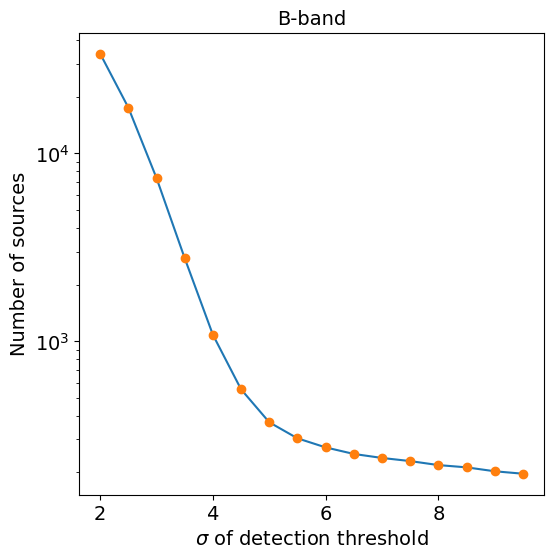

In [66]:
# Now let's create a plot to show how the number of detected sources changes with different detection thresholds.
thresharr = np.arange(2., 10., 0.5)  # Create an array of thresholds from 2 to 9, in steps of 0.5.
nsources_b = np.zeros(len(thresharr))  # Initialize an empty array to store the number of sources for each threshold.

# Loop through each threshold in the threshold array.
for ithresh, thresh in enumerate(thresharr):
    # For each threshold, create a DAOStarFinder object with the given threshold and FWHM.
    daofind = DAOStarFinder(fwhm=4.3, threshold=thresh*std_b)
    # Run the DAOStarFinder to detect stars in the image, subtracting the background.
    sources_btmp = daofind(data_b - median_b)
    # Store the number of sources found at this threshold.
    nsources_b[ithresh] = len(sources_btmp)

# Now, let's create a plot to visualize how the number of sources varies with the detection threshold.
fig, ax = plt.subplots(figsize=(6, 6))  # Set up a square figure (6x6 inches).

# Plot the number of sources vs the detection threshold.
ax.plot(thresharr, nsources_b)  # Plot the line.
ax.plot(thresharr, nsources_b, 'o')  # Plot the points as circles on the line.

# Set the y-axis to a logarithmic scale to better see changes over a wide range of source counts.
ax.set_yscale('log')

# Set labels and title for the plot.
ax.set_ylabel('Number of sources', fontsize=14)  # Label for the y-axis.
ax.set_xlabel(r'$\sigma$ of detection threshold', fontsize=14)  # Label for the x-axis, with LaTeX formatting.
ax.tick_params(axis='x', labelsize=14)  # Set the font size for x-axis ticks.
ax.tick_params(axis='y', labelsize=14)  # Set the font size for y-axis ticks.

# Set the title of the plot.
ax.set_title('B-band', fontsize=14)




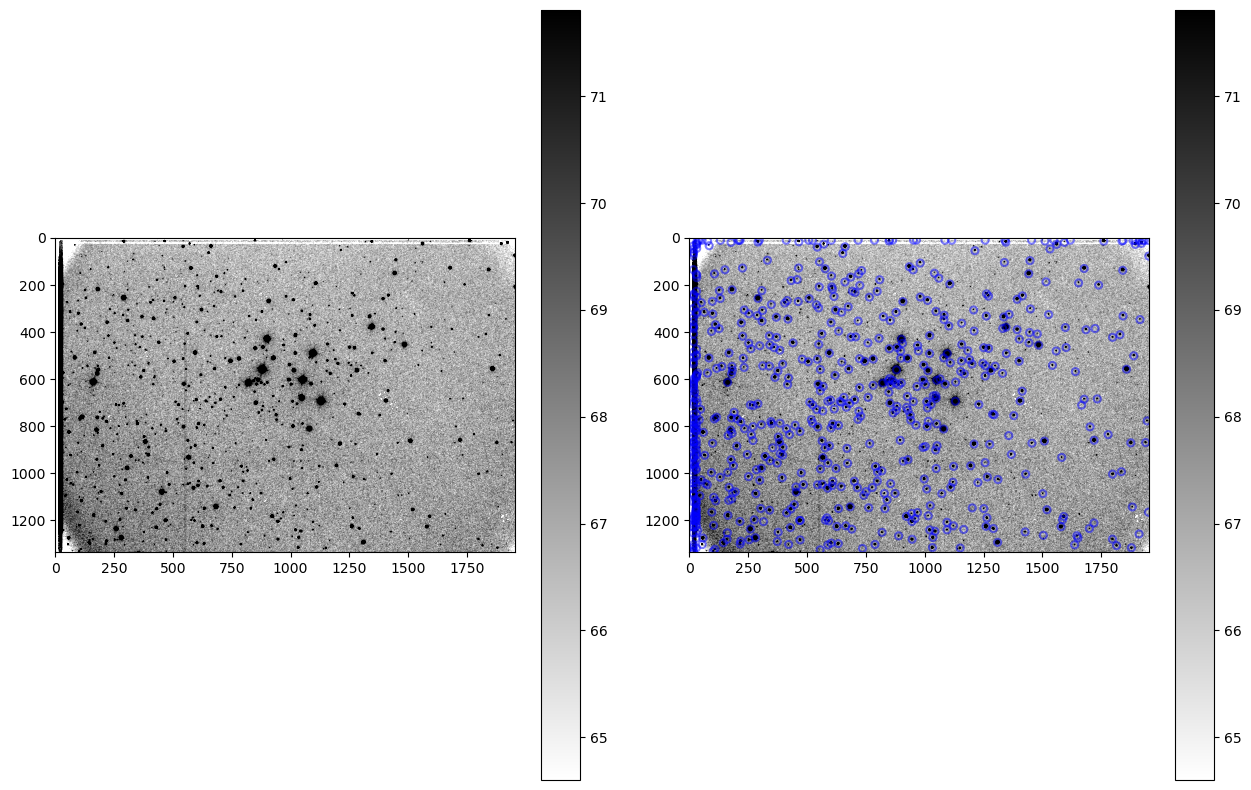

In [67]:
#********************
# Now we're going to do the same process for the V-band image.
# Let's load the data and process it the same way we did for the B-band image.
data_g, header_g = fits.getdata('M29G.fits', header=True)  # Read the V-band image data and header.

# Use sigma clipping to calculate the mean, median, and standard deviation of the image.
# The sigma_clipped_stats function removes outliers based on a sigma value of 3.
mean_g, median_g, std_g = sigma_clipped_stats(data_g, sigma=3.0)  # Compute the stats with a 3-sigma clip.

# Set up the DAOStarFinder with the same FWHM value (for star size) and a threshold based on the image's standard deviation.
# We're using the corrected threshold value here.
daofind = DAOStarFinder(fwhm=4.3, threshold=5.*std_g)  # Detect stars using the DAOStarFinder.

# Detect sources in the image by subtracting the background (sky) using the median.
sources_g = daofind(data_g - median_g)  # Run the star-finding algorithm on the sky-subtracted image.

# Convert the pixel coordinates of the detected stars into RA (Right Ascension) and Dec (Declination)
# using the WCS (World Coordinate System) information from the image header.
wcs_g = WCS(header_g)  # Get the WCS info from the V-band image header.
ra_g, dec_g = wcs_g.wcs_pix2world(sources_g['xcentroid'], sources_g['ycentroid'], 0) 
# Convert the pixel positions to RA/Dec.

# Let's plot the V-band image and the detected stars.
plt.figure(figsize=(15, 10))  # Set up the figure size.

# On the left, display the raw V-band image.
plt.subplot(1, 2, 1)  # First subplot in a 1x2 grid.
imdisplay(data_g)  # Show the V-band image.

# On the right, we'll display the V-band image again but with circles marking the detected stars.
plt.subplot(1, 2, 2)  # Second subplot in the grid.
# Get the positions of the stars and format them correctly.
positions = np.transpose((sources_g['xcentroid'], sources_g['ycentroid']))  
# Create circular apertures (15 pixels in radius) at each star position.
apertures = CircularAperture(positions, r=15.)  
imdisplay(data_g)  # Display the V-band image again.

# Overlay the circular apertures on top of the image to show where the stars are.
# These blue circles represent the stars detected by the DAOStarFinder.
# The ';' at the end just stops any extra output from showing in the console.
apertures.plot(color='blue', lw=1.5, alpha=0.5);  # Plot the apertures with blue circles and transparency.


Text(0.5, 1.0, 'G-band')

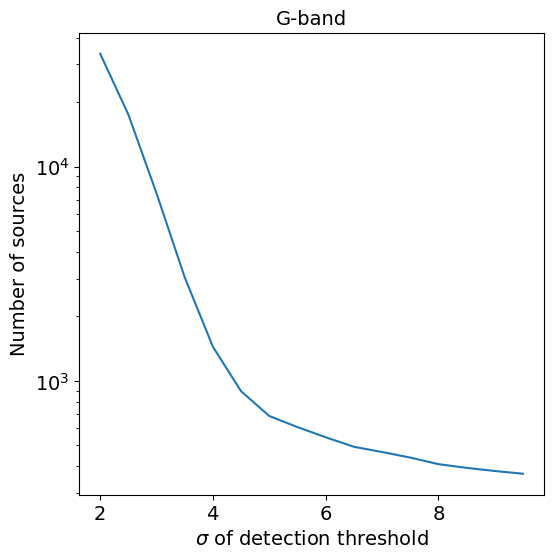

In [68]:
# Now, we want to create a plot showing how the number of detected sources changes with different detection thresholds.
thresharr = np.arange(2., 10., 0.5)  # Create an array of detection thresholds from 2 to 9, in steps of 0.5.
nsources_v = np.zeros(len(thresharr))  # Initialize an empty array to store the number of sources for each threshold.

# Loop through each threshold in the threshold array.
for ithresh, thresh in enumerate(thresharr):
    # For each threshold, create a DAOStarFinder object, using the threshold and FWHM value for star detection.
    daofind = DAOStarFinder(fwhm=3.9, threshold=thresh*std_g)
    # Run the DAOStarFinder to detect sources in the G-band image, subtracting the median background.
    sources_vtmp = daofind(data_g - median_g)
    # Store the number of sources detected for this threshold.
    nsources_v[ithresh] = len(sources_vtmp)

# Now, let's create a plot to visualize how the number of detected sources varies with the detection threshold.
fig, ax = plt.subplots(figsize=(6, 6))  # Create a square plot (6x6 inches).

# Plot the number of sources detected for each threshold.
ax.plot(thresharr, nsources_v)  # Plot a line showing the number of sources for each threshold.
# You can also add markers (e.g., circles) at each threshold value.
ax.set_yscale('log')  # Set the y-axis to a logarithmic scale to better display the number of sources.

# Set labels for the axes and the plot title.
ax.set_ylabel('Number of sources', fontsize=14)  # Label for the y-axis (number of detected sources).
ax.set_xlabel(r'$\sigma$ of detection threshold', fontsize=14)  # Label for the x-axis, formatted with LaTeX.
ax.tick_params(axis='x', labelsize=14)  # Set the font size for x-axis tick labels.
ax.tick_params(axis='y', labelsize=14)  # Set the font size for y-axis tick labels.

# Set the title of the plot to indicate this is for the G-band.
ax.set_title('G-band', fontsize=14)


## Problem 5 - Compare the positions of the V and B-band sources (6 points)

* Make a plot of the DEC vs RA of the sources in the B and V images.
* Plot each set with a separate marker.
* <font color='red'> answer the question </font> Are the same sources detected in each image?  If not, which images has more sources and why?


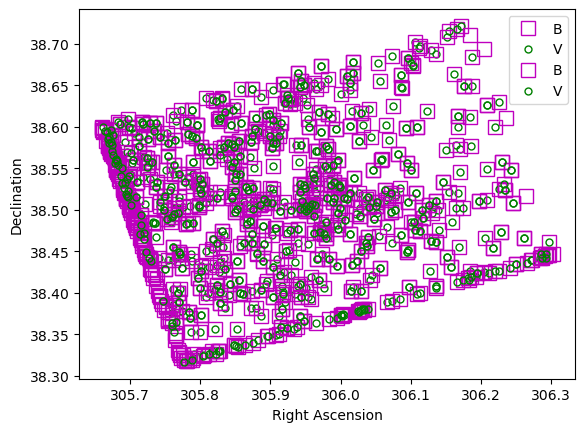

In [69]:
#*************************
# make a plot of the RA and DEC of the sources in the B and V images
# Create a new figure for plotting
plt.figure()

# Define RA and Dec for B and G band sources
B = ra_b, dec_b 
G = ra_g, dec_g

# Set a buffer distance to avoid edges in the image
buff = 50

# Determine valid positions in the B and G-band images, avoiding the image boundaries
# Create boolean flags for sources within the valid region for B and G bands
NEF_b = (sources_b['xcentroid'] > buff) & (sources_b['xcentroid'] < header_b['NAXIS1'] - buff)
NEF_g = (sources_g['xcentroid'] > buff) & (sources_g['xcentroid'] < header_g['NAXIS1'] - buff)

# Plot the valid B-band source positions (only those within the valid region)
plt.plot(ra_b[NEF_b], dec_b[NEF_b], 'ms', mfc='None', markersize=10, label='B')

# Plot the valid G-band source positions (only those within the valid region)
plt.plot(ra_g[NEF_g], dec_g[NEF_g], 'g.', mfc='None', markersize=10, label='V')

# Count the number of valid sources in B and V bands
nsource_b = sum(NEF_b)
nsource_v = sum(NEF_g)

# (Redundant plotting) Plot the positions of all B sources (including those outside the valid region)
plt.plot(ra_g, dec_g, 'ms', mfc='None', markersize=10, label='B')

# (Redundant plotting) Plot the positions of all V sources (including those outside the valid region)
plt.plot(ra_b, dec_b, 'g.', mfc='None', markersize=10, label='V')

# Add a legend to the plot
plt.legend()

# Set the x-axis label as Right Ascension
plt.xlabel('Right Ascension')

# Set the y-axis label as Declination
plt.ylabel('Declination')

# Save the resulting plot as an image file
plt.savefig('img.png')


## Match the catalogs of the B and V photometry

We can match the sources in the two catalogs using their RA and DEC

In [70]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [71]:
#this creates a SkyCoord object containing the B and V catalogs
b_catalog = SkyCoord(ra=ra_b*u.degree, dec=dec_b*u.degree)
g_catalog = SkyCoord(ra=ra_g*u.degree, dec=dec_g*u.degree)

#this matches the two catalogs and outputs an array of indices, idx that when passed to v_catalog
#gives the ids of the match sources in the b_catalog.
idx, d2d, d3d = b_catalog.match_to_catalog_sky(g_catalog)

# we are going to keep matches that have offsets less than 5 arcseconds
# NOTE: this might not be small enough if you were
# matching stars in a globular cluster
matchflag = d2d < 5./3600*u.deg
bmag = sources_b['mag'][matchflag]
gmag = sources_g['mag'][idx[matchflag]]
print(bmag)
print(gmag)

        mag         
--------------------
 -0.7903161664364994
-0.20961119382865967
 -1.4084166008379284
 -3.2350031312465806
 -1.0677479615514782
 -2.2252828387878916
  -1.659403755158595
  -2.504306618565778
 -0.4575767830680983
  -3.329371573454112
                 ...
  -4.209477780813509
   -1.38845249199271
 -1.6496648397493567
 -1.4506549296926026
 -0.8715761700811422
 -0.3935574050985653
 -0.4441818543851064
 -1.4861476497919033
-0.26535769096676093
-0.02525451675180089
Length = 305 rows
        mag        
-------------------
-0.7475582466694806
-0.6425343665761764
 -2.299984861733941
-3.9991978025143524
-2.1211205373788995
-3.1564191912013575
-2.5263761194768994
-3.1747503228999823
-1.5338651357191853
 -4.024856765019785
                ...
 -5.322322795001009
-2.3733627197807055
 -2.670847550948565
-2.5267968416816524
-1.6797036947469142
-1.4746629569052838
-1.4803016300964345
-2.3384598437581476
-1.4537211057323525
 -1.241127601006027
Length = 305 rows


### Adjust the magnitudes

`daofind` assumes a photometric ZP of zero.  In otherwords, it reports magnitudes as

$$ mag = -2.5 \log_{10}(flux) $$

Compare this to the calibrated magnitudes which we would calculate as:


$$ mag = -2.5 \log_{10}(flux) + ZP$$

Using this and the ZP for each image (reported in the image header as PHOTZP), correct the B and V magnitudes.  

The PHOTZP has been determined by me using PAN-STARRS photometry of stars in our field.

## Problem 6 - convert instrumental magnitudes to calibrated magnitudes (6 points)

In [75]:
#***********************
# Convert instrumental magnitudes to calibrated magnitudes for each band

# The calibrated B-band magnitude is obtained by adding the photometric zero point (PHOTZP) 
# from the header of the B-band image to the instrumental B-band magnitude (bmag)
B_calibrado = bmag + float(header_b['PHOTZP'])

# Similarly, the calibrated G-band magnitude is calculated by adding the PHOTZP 
# from the header of the G-band image to the instrumental G-band magnitude (gmag)
G_calibrado = gmag + float(header_g['PHOTZP'])

# Print the calibrated B-band and G-band magnitudes to check the results
print(B_calibrado)
print(G_calibrado)


       mag        
------------------
  16.2096838335635
 16.79038880617134
15.591583399162072
 13.76499686875342
15.932252038448521
 14.77471716121211
15.340596244841405
14.495693381434222
  16.5424232169319
13.670628426545889
               ...
12.790522219186492
 15.61154750800729
15.350335160250644
15.549345070307398
 16.12842382991886
16.606442594901434
16.555818145614893
15.513852350208097
 16.73464230903324
  16.9747454832482
Length = 305 rows
       mag        
------------------
 16.25244175333052
16.357465633423825
14.700015138266059
13.000802197485648
  14.8788794626211
13.843580808798642
  14.4736238805231
13.825249677100018
15.466134864280814
12.975143234980216
               ...
11.677677204998991
14.626637280219295
14.329152449051435
14.473203158318348
15.320296305253086
15.525337043094716
15.519698369903566
14.661540156241852
15.546278894267648
15.758872398993972
Length = 305 rows


## Problem 7 - plot a color-magnitude diagram (6 points)

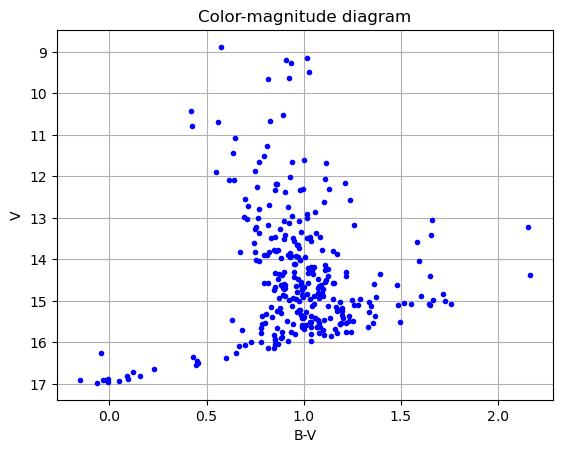

In [73]:
#**************************
# Plotting the Color-Magnitude Diagram

# Calculate the color index (B-V) by subtracting calibrated G-band from B-band
V_calibrado = B_calibrado - G_calibrado 

# Plot the color-magnitude diagram with B-V on the x-axis and V on the y-axis
# 'b.' represents blue points for each source
plt.plot(V_calibrado, G_calibrado, 'b.')

# Invert the y-axis to display brighter sources at the top (common for magnitude plots)
plt.gca().invert_yaxis()

# Label the x-axis as 'B-V' to indicate the color index
plt.xlabel('B-V')

# Label the y-axis as 'V' to indicate the calibrated V-band magnitudes
plt.ylabel('V')

# Add a title to the plot for clarity
plt.title('Color-magnitude diagram')

# Display grid lines for easier visual interpretation of the diagram
plt.grid(True)


## Problem 8 - Summarize the CMD (6 points)
Write about the main features of the H-R diagram that you see.  Note that we have not selected members and that there may be contaminants in this field.  I would like you to point out what you think are the astrophysically meaningful regions of this diagram and indicate stars to highlight your points.   If you wish to draw on your figure to annotate it, save the figure and load it into another program, like google slides, to draw on it.

Given that the B and V bands each have their own magnitude limit, describe mathematically the faintest magnitude you see at every color. 


**put answer here:** The straight line from the middle center to the top center could be the main sequence. I also was thinking that another representation of the main sequence in the plot could be from the lower left point to the lower right side  could be the main sequence in the plot. Also the point were the stars leave the main sequence is when the start being brighter than the average.

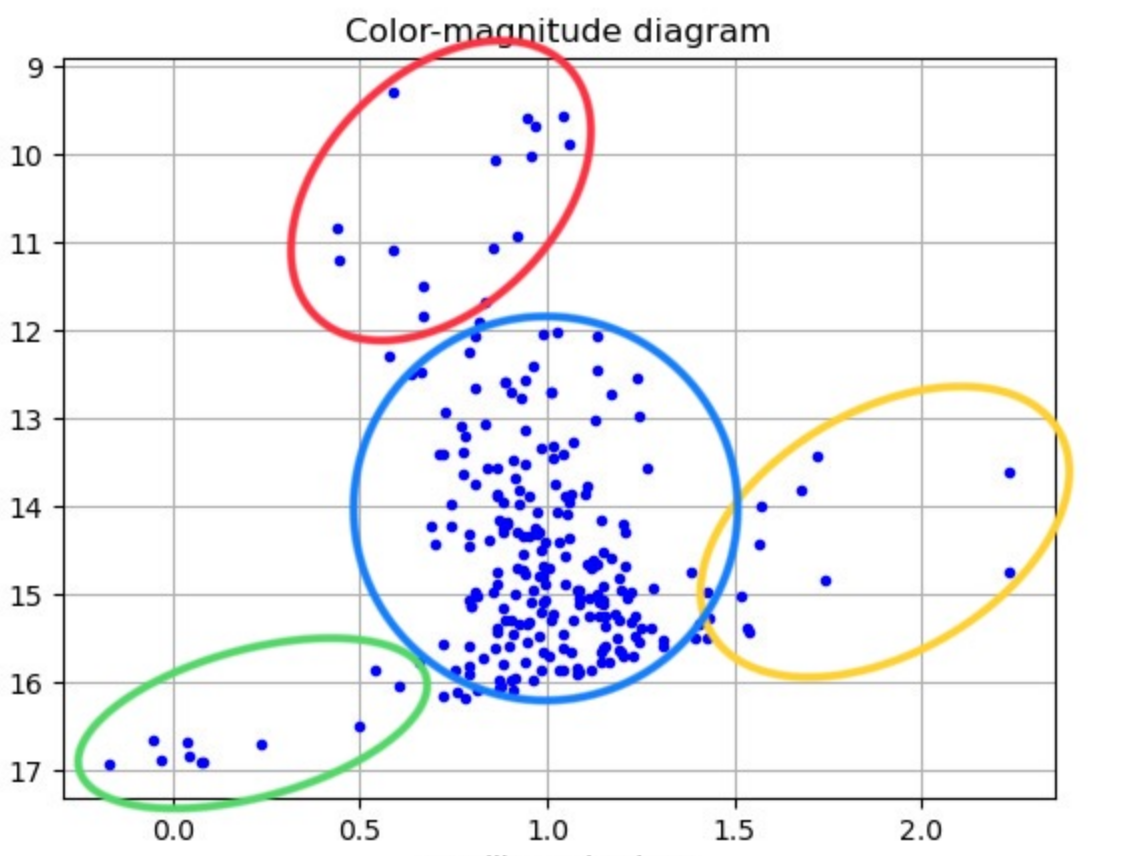

In [74]:
from IPython.display import Image
Image(filename='IMAGEN.png') #this has the wrong axis 


<h5>Notes about the plot here: </h5> 
Lets start with the red circle: The few starts that are in the upper part of the diagram could be stars between us and the cluster because there is not supoposed to be stars above the point where stars leave the main sequence. The second explanation of that stars being located in the upper part could be because all the stars were formed at the same time. Now with the yellow circle, theh stars that are in this part could be fainter/cooler/dimmer stars and that is why their location is not in the main sequence. Since I made the asusmption that the main sequence is in the middle of the plot I will also make the assumption that the stars in the green circle are white dwarfs. Finally, if neither of my assumption is correct I dare to say that the point that are in the lower part of teh diagram are due to contaminants either from the detector or are stars inbetween us as observers and the cluster.
There is a cutoff at the bottom of the plot due to the detection limit in both bands. This cutoff results from the fact that, for a fixed limiting magnitude in the B-band, sources with redder colors (larger \( B-V \)) must have a brighter V-band magnitude. This ensures that the V-band magnitude is not fainter than the B-band magnitude. The relationship can be expressed as:

$$ V_{faint} = B_{faint} - (B-V) $$

